## Introduction

The data is a part of the 2015 Behavioral Risk Factor Surveillance System annual survey done by the CDC. The subset I am using was made by Alex Taboul on github, in which he consolidated the original dataset to include only the columns he determined to be relevant to diabetes detection. The original dataset contains responses from 441,455 individuals and has 330 features, while the dataset I used is comprised of 253,680 responses and 22 variables total. The features consist of things like high cholesterol or blood pressure, smoker status, age, BMI, sex and income. All of the features are categorical, ranging from binary to 30, except for BMI. 
I am using two different versions of the dataset, one binary which contains diabetic (which is a combination of  pre-diabetic and diabetic) & non-diabetic, and one multiclass which separates the three.

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFpr, chi2

import pickle 

Loading data

In [4]:
diabetes_bin = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')

## Data Exploration
Checking for imbalance, nulls and duplicates

Checking correlation scores

Text(0, 0.5, 'Frequency')

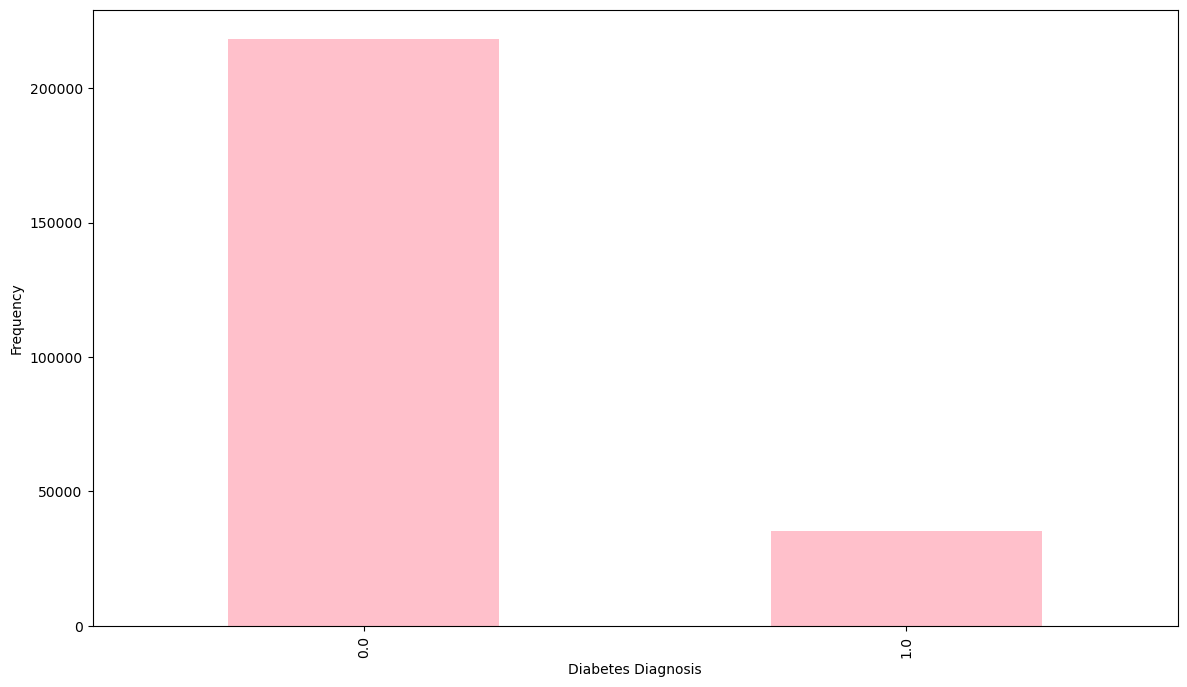

In [5]:
ax = diabetes_bin['Diabetes_binary'].value_counts().plot(kind='bar',
                                    figsize=(14,8), color = 'pink')
ax.set_xlabel("Diabetes Diagnosis")
ax.set_ylabel("Frequency")

In [7]:
diabetes_bin.isna().any()

Diabetes_binary         False
HighBP                  False
HighChol                False
CholCheck               False
BMI                     False
Smoker                  False
Stroke                  False
HeartDiseaseorAttack    False
PhysActivity            False
Fruits                  False
Veggies                 False
HvyAlcoholConsump       False
AnyHealthcare           False
NoDocbcCost             False
GenHlth                 False
MentHlth                False
PhysHlth                False
DiffWalk                False
Sex                     False
Age                     False
Education               False
Income                  False
dtype: bool

In [9]:
diabetes_bin.duplicated().any()

True

In [4]:
cols = diabetes_bin.columns.tolist()
for col in cols[1:]:
    print(f' correlation for {col} : {diabetes_bin["Diabetes_binary"].corr(diabetes_bin[col])}')

 correlation for HighBP : 0.26312878992336225
 correlation for HighChol : 0.20027619187911974
 correlation for CholCheck : 0.06476081015893663
 correlation for BMI : 0.21684306020311908
 correlation for Smoker : 0.060788505640340836
 correlation for Stroke : 0.10581606726811349
 correlation for HeartDiseaseorAttack : 0.17728225780720322
 correlation for PhysActivity : -0.11813311489591109
 correlation for Fruits : -0.040779228104065375
 correlation for Veggies : -0.05658413706416273
 correlation for HvyAlcoholConsump : -0.057056256121682455
 correlation for AnyHealthcare : 0.01625513954586572
 correlation for NoDocbcCost : 0.03143276335925929
 correlation for GenHlth : 0.2935690630787161
 correlation for MentHlth : 0.06931508263835504
 correlation for PhysHlth : 0.17133670038725263
 correlation for DiffWalk : 0.21834435192101767
 correlation for Sex : 0.03142999802068101
 correlation for Age : 0.17744187216725688
 correlation for Education : -0.12445596921588226
 correlation for Income

### Data Exploration Results
The dataset has a pretty large imbalance, with over a 6:1 ratio of non-diabetic to diabetic. This can impact the results as the model will be much better trained on non diabetic compared to diabetic/pre-diabetic. This could lead to false negatives, in which someone who should be categorized as 1 (diabetic), may be categorized as 0. 
The dataset I used was cleaned, so there were no nulls. There are duplicates in the dataset but I decided not to remove them, as with a medical dataset like this, each record is valuable in training the model. Also, duplicate records do not necessarily indicate error in this case as some individuals may have the same records.  
I looked at the correlation scores of each feature with the label, and all of them seem to be correlated with the label, with the lowest correlation being with the feature that indicates if the patient had healthcare or not. 

Splitting data using 0.20 test size + stratifying on label column


In [29]:

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(diabetes_bin.iloc[:,1:], 
                                                    diabetes_bin['Diabetes_binary'], 
                                                    test_size= 0.20, random_state= 777, 
                                                    shuffle = True, stratify= diabetes_bin['Diabetes_binary'])

### Feature selection
The correlation scores were not definitive enough, so I decide to use the chi2 test with an alpha of 0.01 to determine the feature importance. This resulted in all features except one (AnyHealthcare) being significant.

In [31]:
fpr = SelectFpr(chi2, alpha=0.01)
X_train_bin = fpr.fit_transform(X_train_bin, y_train_bin)
features_after_fpr = fpr.get_feature_names_out()
feature_mask = np.isin(cols[1:],features_after_fpr)
dropped_idx = np.where(feature_mask == False)[0]
dropped_col = cols[12]
# AnyHealthcare is dropped column 

### BINARY CLASSIFICATION MODELS

Random Forest

In [7]:
params_rf = {'n_estimators':np.arange(1000,4000,1000),
          'max_depth':[13,14,15,16,None],
          'max_features':['sqrt',0.5]}
clf_rf_bin = RandomForestClassifier(random_state= 777, oob_score= True)
gcv_rf_bin = GridSearchCV(clf_rf_bin, param_grid= params_rf, 
                   n_jobs = 4, cv = 5, 
                   return_train_score = True, 
                   scoring = ['f1_weighted'], 
                   refit = 'f1_weighted').fit(X_train_bin,y_train_bin)
print(f'best validation F1 score: {gcv_rf_bin.cv_results_["mean_test_f1_weighted"][gcv_rf_bin.best_index_]}')
print(f'best training F1 score: {gcv_rf_bin.cv_results_["mean_train_f1_weighted"][gcv_rf_bin.best_index_]}')
print(f'best hyperparameters: {gcv_rf_bin.best_params_}')

best validation F1 score: 0.8326137245769045
best training F1 score: 0.921390247664305
best hyperparameters: {'max_depth': 16, 'max_features': 0.5, 'n_estimators': 1000}


Confusion Matrix for Random Forest using training set

Text(50.722222222222214, 0.5, 'True')

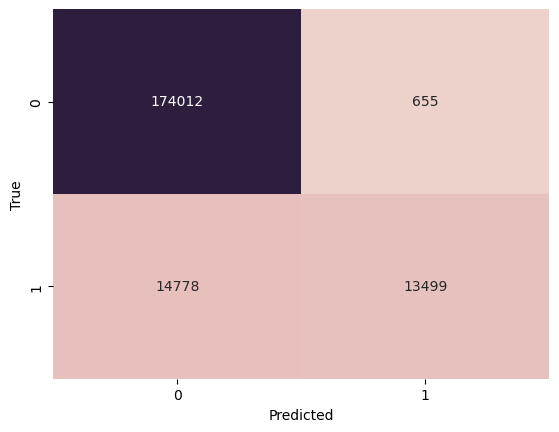

In [49]:
y_pred_rf_bin = gcv_rf_bin.best_estimator_.predict(X_train_bin)
conf_mat_rf_bin = confusion_matrix(y_true = y_train_bin, y_pred= y_pred_rf_bin)
axes = sns.heatmap(conf_mat_rf_bin, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

Gradient Boosting

In [9]:
params_hgb = {'max_iter':np.arange(1000,4000,1000),
          'max_depth':[13,14,15,16,None],
          'min_samples_leaf':[40,60,80,100],
          'learning_rate': [0.001,0.01,0.1]}
clf_hgb_bin = HistGradientBoostingClassifier(random_state= 777, categorical_features= [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
gcv_hgb_bin = GridSearchCV(clf_hgb_bin, param_grid= params_hgb, n_jobs = 4, 
                   cv = 5, return_train_score = True, 
                   scoring = ['f1_weighted'], 
                   refit = 'f1_weighted').fit(X_train_bin,y_train_bin)

print(f'best validation F1 score: {gcv_hgb_bin.cv_results_["mean_test_f1_weighted"][gcv_hgb_bin.best_index_]}')
print(f'best training F1 score: {gcv_hgb_bin.cv_results_["mean_train_f1_weighted"][gcv_hgb_bin.best_index_]}')
print(f'best hyperparameters: {gcv_hgb_bin.best_params_}')

best validation F1 score: 0.8324644102586912
best training F1 score: 0.8370754576568826
best hyperparameters: {'learning_rate': 0.1, 'max_depth': 13, 'max_iter': 1000, 'min_samples_leaf': 80}


Confusion Matrix for Gradient Boosted Trees using training set

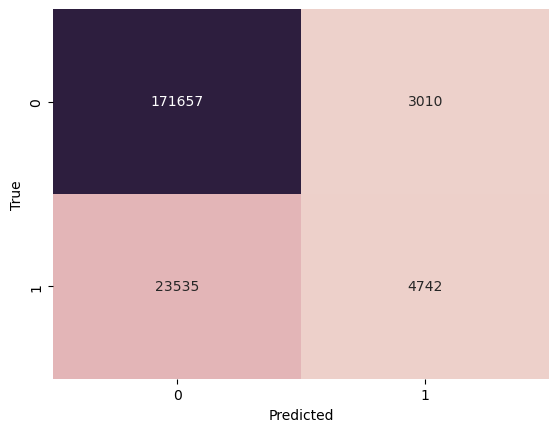

In [48]:
y_pred_hgb_bin = gcv_hgb_bin.best_estimator_.predict(X_train_bin)
conf_mat_hgb_bin = confusion_matrix(y_true = y_train_bin, y_pred= y_pred_hgb_bin)
axes = sns.heatmap(conf_mat_hgb_bin, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')
plt.show()

### Evaluating Test Set
Confusion Matrix + f1 score

c:\Users\pixie\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


0.8321619083504609

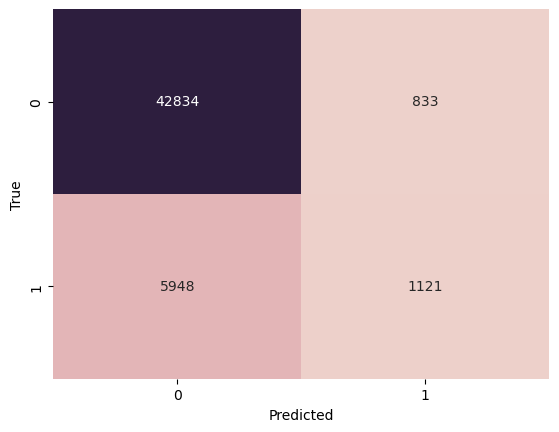

In [41]:
y_pred_test_bin = gcv_hgb_bin.best_estimator_.predict(X_test_bin.drop('AnyHealthcare', axis = 1))
conf_mat_test_bin = confusion_matrix(y_true = y_test_bin, y_pred= y_pred_test_bin)
axes = sns.heatmap(conf_mat_test_bin, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

f1_score(y_test_bin, y_pred_test_bin, average= 'weighted')

### MULTICLASS CLASSIFICATION MODELS 

loading data

In [35]:
diabetes_mc = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
diabetes_mc.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Splitting data using 0.20 test size + stratifying on label column

In [36]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(diabetes_mc.iloc[:,1:], 
                                                    diabetes_mc['Diabetes_012'], 
                                                    test_size= 0.20, random_state= 777, 
                                                    shuffle = True, 
                                                    stratify= diabetes_mc['Diabetes_012'])

Feature selection

AnyHealthcare column is dropped again

In [42]:
fpr = SelectFpr(chi2, alpha=0.01)
X_train_mc = fpr.fit_transform(X_train_mc, y_train_mc)
features_after_fpr_mc = fpr.get_feature_names_out()
feature_mask_mc = np.isin(cols[1:],features_after_fpr_mc)
dropped_idx_mc = np.where(feature_mask_mc == False)[0]
dropped_col_mc = cols[12]
# AnyHealthcare is dropped column 

Random Forest

In [43]:
clf_rf_mc = RandomForestClassifier(random_state= 777, oob_score= True)
gcv_rf_mc = GridSearchCV(clf_rf_mc, param_grid= params_rf, 
                   n_jobs = 4, cv = 5, 
                   return_train_score = True, 
                   scoring = ['f1_weighted'], 
                   refit = 'f1_weighted').fit(X_train_mc,y_train_mc)
print(f'best validation F1 score: {gcv_rf_mc.cv_results_["mean_test_f1_weighted"][gcv_rf_mc.best_index_]}')
print(f'best training F1 score: {gcv_rf_mc.cv_results_["mean_train_f1_weighted"][gcv_rf_mc.best_index_]}')
print(f'best hyperparameters: {gcv_rf_mc.best_params_}')

best validation F1 score: 0.8106339494221981
best training F1 score: 0.9059562693250826
best hyperparameters: {'max_depth': 16, 'max_features': 0.5, 'n_estimators': 3000}


Confusion Matrix for Random Forest using training set

Text(50.722222222222214, 0.5, 'True')

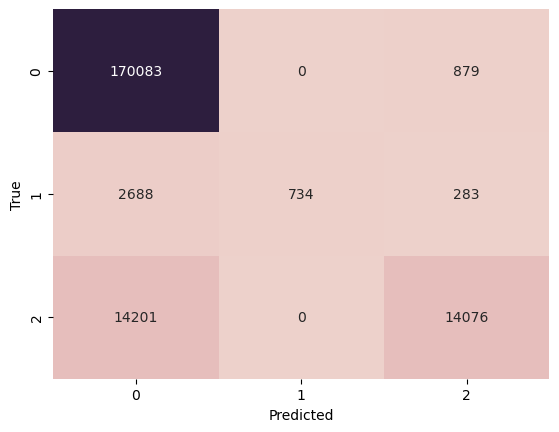

In [44]:
y_pred_rf_mc = gcv_rf_mc.best_estimator_.predict(X_train_mc)
conf_mat_rf_mc = confusion_matrix(y_true = y_train_mc, y_pred= y_pred_rf_mc)
axes = sns.heatmap(conf_mat_rf_mc, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

Gradient Boosting

In [45]:
clf_hgb_mc = HistGradientBoostingClassifier(random_state= 777, categorical_features= [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
gcv_hgb_mc = GridSearchCV(clf_hgb_mc, param_grid= params_hgb, n_jobs = 4, 
                   cv = 5, return_train_score = True, 
                   scoring = ['f1_weighted'], 
                   refit = 'f1_weighted').fit(X_train_mc,y_train_mc)

print(f'best validation F1 score: {gcv_hgb_mc.cv_results_["mean_test_f1_weighted"][gcv_hgb_mc.best_index_]}')
print(f'best training F1 score: {gcv_hgb_mc.cv_results_["mean_train_f1_weighted"][gcv_hgb_mc.best_index_]}')
print(f'best hyperparameters: {gcv_hgb_mc.best_params_}')

best validation F1 score: 0.8118012596369348
best training F1 score: 0.8172454556115284
best hyperparameters: {'learning_rate': 0.1, 'max_depth': 16, 'max_iter': 1000, 'min_samples_leaf': 60}


Confusion Matrix for Gradient Boosting using training set

Text(50.722222222222214, 0.5, 'True')

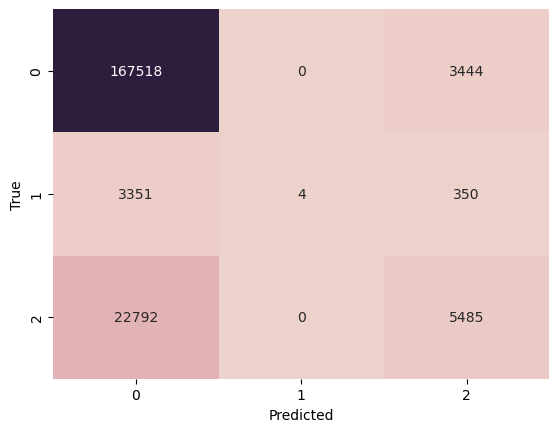

In [46]:
y_pred_hgb_mc = gcv_hgb_mc.best_estimator_.predict(X_train_mc)
conf_mat_hgb_mc = confusion_matrix(y_true = y_train_mc, y_pred= y_pred_hgb_mc)
axes = sns.heatmap(conf_mat_hgb_mc, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

# use predict on test data, use f1 score function with weighted + do confusion matrix 

### Evaluating Test Set
Confusion Matrix + f1 score

c:\Users\pixie\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


0.8120089416196272

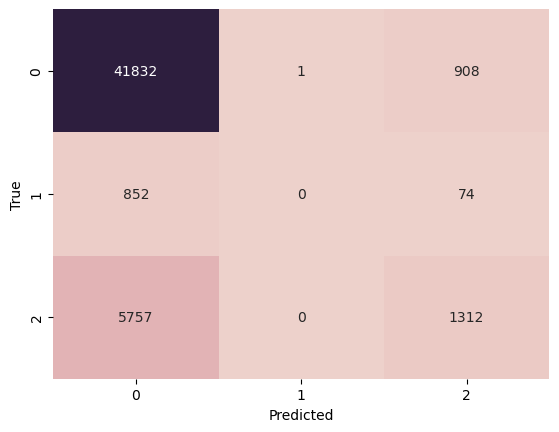

In [47]:
y_pred_test_mc = gcv_hgb_mc.best_estimator_.predict(X_test_mc.drop('AnyHealthcare', axis = 1))
conf_mat_test_mc = confusion_matrix(y_true = y_test_mc, y_pred= y_pred_test_mc)
axes = sns.heatmap(conf_mat_test_mc, cbar= False, annot= True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True))
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

f1_score(y_test_mc, y_pred_test_mc, average= 'weighted')

### Methods Review

The plan for this project was to build baseline classifiers for both the binary and multiclass datasets. I decided on using RandomForest and HistGradientBoost, which is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000).
I split the data using a 20% test size and stratified with label column. I then did feature selection using chi2 and an alpha value of 0.01 to transform the training data, which resulted in one dropped feature, any healthcare.  
I then used gridsearchcv to tune the hyperparameters for each model. For the random forest models, I tuned the number of estimators, max depth of each tree, and max features (which determines what portion of the total features are used to randomly train each tree) . For the HistGradientBoost, I tuned the max itererations, max depth, minimum samples per leaf, and learning rate parameters. I used a 5 fold cross validation and the f1 weighted metric. I chose this metric because accuracy is not very reliable for imbalanced data sets and precision + recall are better measures. The F1 score is a harmonic mean of the precision and recall, with its best value at 1 and worst score at 0. I chose the weighted version to provide the correct weights to the imbalanced classes. 




### Discussion
I started with the hypothesis that I can build a diabetes classifier for both the binary and multiclass diabetes datasets.  The results of this project show that it is possible, but I definitely think that there is room for improvement. Correcting the data imbalance would be the first thing I would do. 
Both the algorithms I used for this project allow me to specify custom weights for the labels to account for imbalance, so changing those would be the first step in improving imbalance. I have also read of something called synthetic resampling (SMOTE), which I have read also helps with correcting imbalance. 
Then I would investigate acquiring additional data, whether it be more samples or more features. I would also look at the features in the original dataset and see if any were left out that could potentially better the model. 
